<h1 align="center">Titanic Dataset Analysis with Linear Models</h1>

<img src="https://img.20mn.fr/CErtKaVbRdGYu9BfHjihKA/640x410_leonardo-dicaprio-kate-winslet-titanic.jpg" width="1280" height="820" align="center"/> 
<h3 align="center">ANGELOT Quentin, LAMONTAGNE Simon, QUEYRICHON Samuel</h3>

# 0 / Imports
### 0.1 Bibliothèques


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import cufflinks as cf
import re
from warnings import simplefilter
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFECV


sns.set(color_codes=True)
%matplotlib inline
py.offline.init_notebook_mode(connected=True)
np.random.seed(64)
simplefilter(action='ignore', category=FutureWarning)

### 0.2 Datasets
Note : les datasets doivent être dans le même dossier que le notebook.

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 1 / Exploration du Dataset
## 1.1 Analyse préliminaire

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Le dataset d'entraînement a 891 lignes (valeurs) et 11 features, ainsi que la variable cible (Survived)**. 2 de ces features sont des floats, 5 sont des ints, et 5 sont des objets. Voici le détail du sens profane de ces features :

**PassengerId** : ID unique du passager<br>
**Survived** : État de vie du passager<br>
**Pclass** : Classe du ticket<br>
> *1 = 1ère classe / 2 = 2ème classe / 3 = 3ème classe*<br>

**Name** : Nom du passager<br>
> *à noter que le nom du passager varie en fonction de son sexe*<br>

**Sex** : Genre du passager<br>
**Age** : Age du passager<br>
**SibSp** : Nombre de frères/soeurs/conjoints à bord du Titanic<br>
**Parch** : Nombre de parents/enfants à bord<br>
**Ticket** : Numero de ticket du passager<br>
**Fare** : Tarif par passager<br>
**Cabin** : Numero de cabine des passagers<br>
**Embarked** : Port d'embarquement<br>  
> *C = Chebourg / Q = Queenstown / S = Southampton*


## 1.2 Analyse des types et des valeurs manquantes

In [4]:
print('Colonne - Type - Nombre de valeurs uniques - %age de valeurs présentes')
print('----------------------------------------------------------------------')
for col in train_df.columns:
    print('%s - %s - %s - %s'%(col,
                               train_df[col].dtypes,
                               len(train_df[col].unique()),
                               int(len(train_df[train_df[col].isnull() == False]) / len(train_df) * 100)))

Colonne - Type - Nombre de valeurs uniques - %age de valeurs présentes
----------------------------------------------------------------------
PassengerId - int64 - 891 - 100
Survived - int64 - 2 - 100
Pclass - int64 - 3 - 100
Name - object - 891 - 100
Sex - object - 2 - 100
Age - float64 - 89 - 80
SibSp - int64 - 7 - 100
Parch - int64 - 7 - 100
Ticket - object - 681 - 100
Fare - float64 - 248 - 100
Cabin - object - 148 - 22
Embarked - object - 4 - 99


On constate que la colonne **Cabin** a un grand nombre de valeurs nulles.
Que la colonne **Embarked** a quelques valeurs nulles (4 exactement)
Que la colonne **Age** a environ 20% de valeurs nulles.

## 1.3 Analyse des données statistiques globales

Commençons par afficher la dataframe et sa méthode describe()

In [5]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


En observant la dataframe, on peut déjà voir qu'on va devoir convertir plusieurs features pour les rendre **numériques**, afin que les algorithmes puissent les traiter. On remarque aussi que les échelles de valeurs sont extremement variés, et qu'on va devoir arranger ça pour qu'elles soient toutes à peu près dans les mêmes échelles.


On peut constater que **38%** des passagers présents dans le dataset ont survécu au naufrage du Titanic. 
Également, leurs âge sont très variés, allant de **5 mois à 80 ans**.


# 2 / Visualisation Exploratoire
On fait des visualisations de données simples sur le dataset brut, afin de se donner une idée des résultats qu'on attends.

#### 2.1 Repartition des Survivants/Morts

On vérifie qu'effectivement, 38% du dataset a survécu au naufrage.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015AF08ED588>],
      dtype=object)

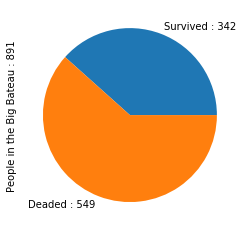

In [7]:
# Survived
a = train_df['Survived'].value_counts()
b = pd.Series({'Survivants : %s'%a[1] : a[1], 'Décédés : %s'%a[0] : a[0]})
b.plot(kind='pie', label='Passagers du Titanic : %s'%(a[0] + a[1]), subplots=True)

#### 2.2 Repartition des classes

On observe qu'une majorité des passagers étaient en 3ème classe.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015AF0C1F3C8>],
      dtype=object)

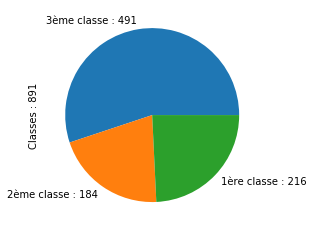

In [8]:
a = train_df['Pclass'].value_counts()
b = pd.Series({'3ème classe : %s'%a[3] : a[3], '2ème classe : %s'%a[2] : a[2], '1ère classe : %s'%a[1] : a[1]})
b.plot(kind='pie', label='Classes : %s'%(a[3] + a[1] + a[2]), subplots=True)

#### 2.3 Tranches d'âge

On observe que la repartition des âges des passagers s'approche d'une loi normale, et que la majorité des passagers avient entre 10 et 40 ans.

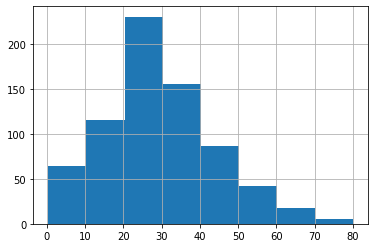

In [9]:
train_df['Age'].hist(bins=8)